# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
from sklearn.preprocessing import StandardScaler
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [3]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    #merged_data.to_netcdf('local_dataset.nc')
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [4]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [5]:
%%time
# Split into training, validation, and test sets
if os.path.isfile('./train_data.nc') and os.path.isfile('./train_data.nc') and os.path.isfile('./test_data.nc'):
    train = xr.open_dataset('./train_data.nc')
    val = xr.open_dataset('./val_data.nc')
    test = xr.open_dataset('./test_data.nc')
else:
    # We only load the train and val sets here to save a couple minutes
    train_files, val_files, test_files = split_data_files()
    train, val, test = map(merge_data, [train_files, val_files, test_files])
    train.to_netcdf('./train_data.nc')
    val.to_netcdf('./val_data.nc')
    test.to_netcdf('./test_data.nc')

CPU times: user 37.5 ms, sys: 15.6 ms, total: 53 ms
Wall time: 132 ms


In [6]:
client.shutdown()

## Exploratory visualizations

When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


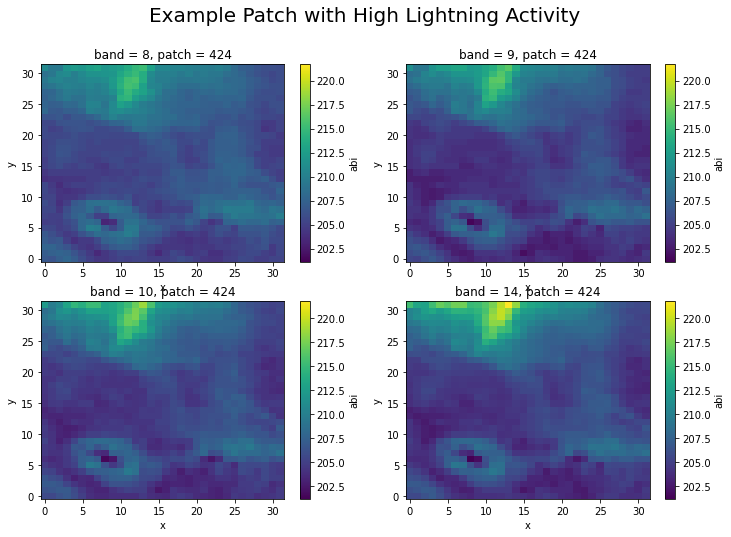

In [7]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[205]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Example Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

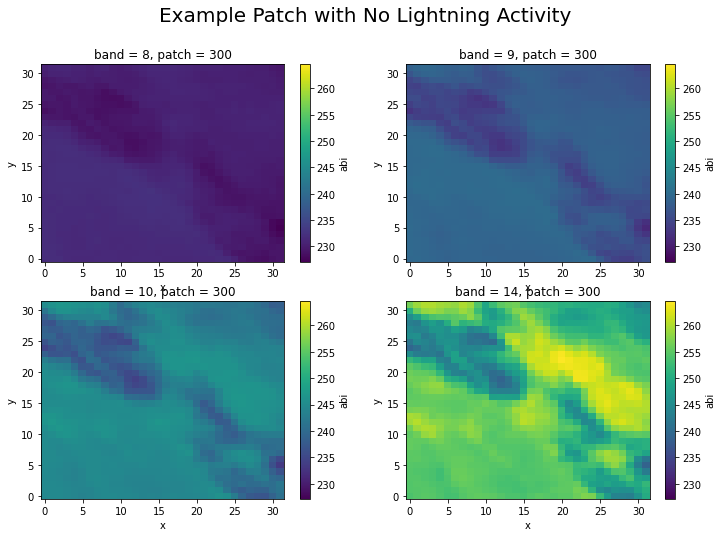

In [8]:
index = no_lc_indices[300]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Example Patch with No Lightning Activity', fontsize=20)

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

In [7]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


CPU times: user 1min 11s, sys: 4.16 s, total: 1min 15s
Wall time: 1min 30s


## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.

### Helper functions and evaluation metrics

In [8]:
def plot_loss(model_history):
    train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
    valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.set_ylim([-0.05,1.05])
    ax1.plot(train_loss, '--', color=color, label='Train Loss')
    ax1.plot(valid_loss, color=color, label='Valid Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(loc='upper left')
    plt.title('Model Loss')
    plt.show()
    
def plot_model_recall_fpr(model_history):
    train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
    valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
    train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
    valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('POD', color=color)
    ax1.set_ylim([-0.05,1.05])
    ax1.plot(train_recall, '--', color=color, label='Train POD')
    ax1.plot(valid_recall, color=color, label='Valid POD')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(loc='upper left')
    plt.title('Model Recall (POD) and False Positive Rate (FAR)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('FAR', color=color)  # we already handled the x-label with ax1
    ax2.plot(train_fpr, '--', color=color, label='Train FAR')
    ax2.plot(valid_fpr, color=color, label='Valid FAR')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-0.05,1.05])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend(loc='upper right')
    plt.show()

class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Arguments:
        y_true  The actual y. Passed by default to Metric classes.
        y_pred  The predicted y. Passed by default to Metric classes.
        
        '''
        # Compute the number of negatives.
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        # Compute the number of false positives.
        y_pred = tf.greater_equal(y_pred, 0.5)  # Using default threshold of 0.5 to call a prediction as positive labeled.
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)

In [9]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def perf_measure(y_true, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    # Sensitivity, hit rate, recall, or true positive rate, or probability of detection
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate or false alarm ratio
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {
        'TP'  : TP,
        'FP'  : FP,
        'TN'  : TN,
        'FN'  : FN,
        'TPR' : TPR,
        'TNR' : TNR,
        'PPV' : PPV,
        'NPV' : NPV,
        'FPR' : FPR,
        'FNR' : FNR,
        'FDR' : FDR,
        'ACC' : ACC,
        }
    

### Visualization

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


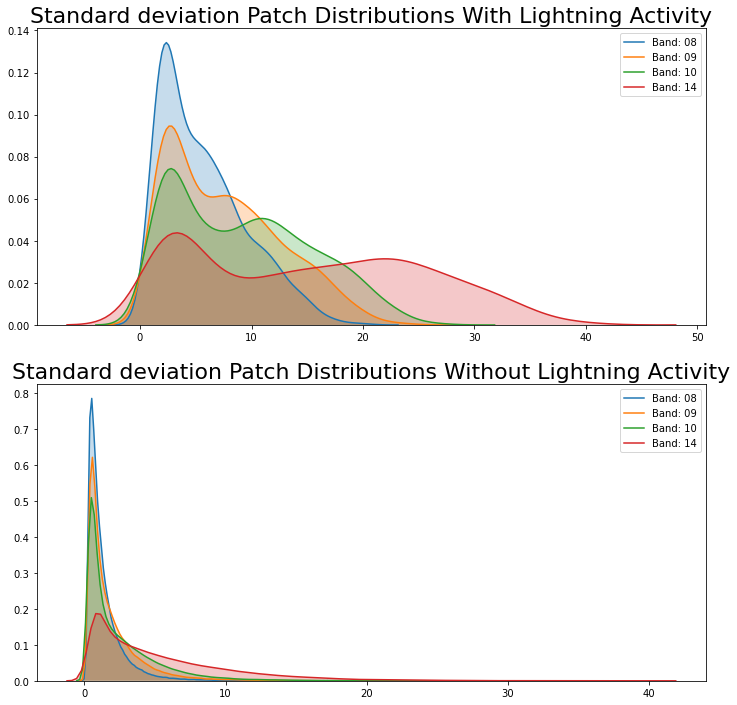

In [13]:
# Plot the standard deviation for exploratory visualization
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity

#standard deviation
std_patches_lc = lc_train.abi.std(dim=('x','y')) # mean BT of each patch
std_patches_no_lc = no_lc_train.abi.std(dim=('x','y')) # mean BT of each patch
fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(std_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Standard deviation Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(std_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Standard deviation Patch Distributions Without Lightning Activity', fontsize=22)

## More data preparation

In [12]:
nsamples_train = train_in.shape[0]
nx = train_in.shape[1]
ny = train_in.shape[2]
nchannels = train_in.shape[3]
print(nsamples_train, nx, ny, nchannels)

212604 32 32 4


In [13]:
nsamples_val = val_in.shape[0]
#nx = val_in.shape[1]
#ny = val_in.shape[2]
#nchannels = val_in.shape[3]
print(nsamples_val, nx, ny, nchannels)

199399 32 32 4


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:
%%time
# Use standard scaler, gives better results with the default ResNet
scaler = StandardScaler()
scaled_train_in = scaler.fit_transform(train_in.reshape(nsamples_train,nx*ny*nchannels))#.reshape(lowres_train_in.shape[0],lowres_patch,lowres_patch,nchannels)
scaled_val_in = scaler.fit_transform(val_in.reshape(nsamples_val,nx*ny*nchannels))#.reshape(lowres_val_in.shape[0],lowres_patch,lowres_patch,nchannels)
print(scaled_train_in.shape)

(212604, 4096)
CPU times: user 36.9 s, sys: 7.3 s, total: 44.2 s
Wall time: 44 s


In [16]:
# Data dimension reduction.
pca = PCA(n_components=32)

In [17]:
%%time
pca_train_in = pca.fit_transform(X=scaled_train_in)
pca_val_in = pca.transform(X=scaled_val_in)

CPU times: user 1min 22s, sys: 5.46 s, total: 1min 27s
Wall time: 28.2 s


(212604, 32)
(212604,)
(199399, 32)
(199399,)


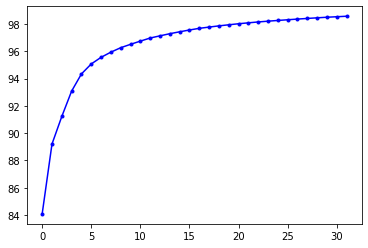

In [22]:
# Cumulative explained variance ratio.
plt.plot(np.cumsum(pca.explained_variance_ratio_*100), ".-b")
print(pca_train_in.shape)
print(train_out.shape)
print(pca_val_in.shape)
print(val_out.shape)

## Default ResNet with StandardScaler

In [24]:
resNet_mod = ResNet(epochs=5, batch_size=512)
vars(resNet_mod)

{'min_filters': 16,
 'filter_width': 3,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'use_dropout': False,
 'pooling': 'mean',
 'dropout_alpha': 0.0,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': None,
 'leaky_alpha': 0.1,
 'batch_size': 512,
 'epochs': 5,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x7f2a7437d490>,
 'loss_history': <goes16ci.models.LossHistory at 0x7f2a74367810>,
 'verbose': 0}

In [25]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in.reshape(nsamples_train,nx,ny,nchannels), train_out, scaled_val_in.reshape(nsamples_val,nx,ny,nchannels), val_out)
resNet_mod.model.summary()

{'loss': 0.07917653769254684, 'val_loss': 0.10222484916448593}
{'loss': 0.06662891060113907, 'val_loss': 0.07929784804582596}
{'loss': 0.06334973126649857, 'val_loss': 0.08872394263744354}
{'loss': 0.061053406447172165, 'val_loss': 0.07704825699329376}
{'loss': 0.05978820100426674, 'val_loss': 0.07491974532604218}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   592         scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d[0][

In [27]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in.reshape(nsamples_val,nx,ny,nchannels)).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)
performance = perf_measure(val_out, binary_preds)

In [28]:
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.274
R squared: 0.697
Hellenger Distance: 0.243
Heidke Skill Score: 0.798
Pierce Skill Score: 0.809
Brier Score: 0.098
Brier Skill Score: 0.591
AUC: 0.904
Probability of detection: 0.914
False alarm ratio: 0.106
Accuracy: 0.902


## Random forest

In [62]:
%%time
from sklearn.ensemble import RandomForestRegressor
# Instance of regressor with default hyperparameters.
RF = RandomForestRegressor(n_jobs=-1, verbose=1)
# Train model
RF.fit(X=pca_train_in, y=train_out)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min


CPU times: user 35min 47s, sys: 0 ns, total: 35min 47s
Wall time: 9min 47s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


RandomForestRegressor(n_jobs=-1, verbose=1)

In [63]:
binary_threshold = 0.5
preds = RF.predict(pca_val_in)
binary_preds = np.where(preds >= binary_threshold, 1, 0)
performance = perf_measure(val_out, binary_preds)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [64]:
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.315
R squared: 0.587
Hellenger Distance: 0.427
Heidke Skill Score: 0.722
Pierce Skill Score: 0.717
Brier Score: 0.132
Brier Skill Score: 0.447
AUC: 0.859
Probability of detection: 0.815
False alarm ratio: 0.098
Accuracy: 0.868


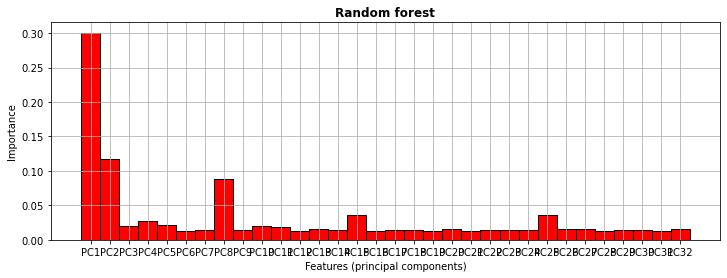

In [67]:
# Random forest feature importance.
plt.figure(figsize=(12, 4))
plt.bar(
    x=range(1, 33), 
    height=RF.feature_importances_, 
    width=1.00, 
    color="red", 
    tick_label=["PC" + str(i) for i in range(1, 33)],
    edgecolor="black"
)
plt.title("Random forest", weight="bold")
plt.xlabel("Features (principal components)")
plt.ylabel("Importance")
plt.grid();

In [70]:
%%time
from sklearn.inspection import permutation_importance
# It takes some time! 17min 4s.
r = permutation_importance(
    estimator=RF, 
    X=pca_val_in, 
    y=val_out,
    n_repeats=30
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_job

CPU times: user 1h 43min 14s, sys: 0 ns, total: 1h 43min 14s
Wall time: 27min 53s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


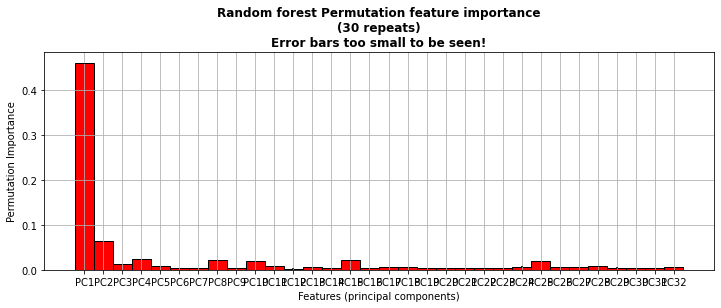

In [71]:
# Random forest permutation feature importance.
plt.figure(figsize=(12, 4))
plt.bar(
    x=range(1, 33), 
    height=r.importances_mean, 
    yerr=r.importances_std,
    width=1.00, 
    color="red",
    ecolor='black',
    tick_label=["PC" + str(i) for i in range(1, 33)],
    edgecolor="black"
)
plt.title("Random forest Permutation feature importance" + \
          "\n(30 repeats)\nError bars too small to be seen!", weight="bold")
plt.xlabel("Features (principal components)")
plt.ylabel("Permutation Importance")
plt.grid();

## Gradient boosted tree

In [58]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
##Train gradient boosted decision trees with default hyperparameters
regressor = GradientBoostingRegressor(
    verbose=1,
    #max_depth=15,
    #n_estimators=10,
    #learning_rate=.5
)
vars(regressor)
regressor.fit(pca_train_in, train_out)

      Iter       Train Loss   Remaining Time 
         1           0.2134            5.31m
         2           0.1982            5.20m
         3           0.1856            5.15m
         4           0.1753            5.11m
         5           0.1660            5.09m
         6           0.1578            5.03m
         7           0.1512            4.97m
         8           0.1453            4.91m
         9           0.1401            4.85m
        10           0.1357            4.80m
        20           0.1116            4.29m
        30           0.1023            3.76m
        40           0.0978            3.23m
        50           0.0953            2.69m
        60           0.0938            2.16m
        70           0.0927            1.62m
        80           0.0919            1.08m
        90           0.0913           32.43s
       100           0.0906            0.00s
CPU times: user 5min 25s, sys: 0 ns, total: 5min 25s
Wall time: 5min 24s


GradientBoostingRegressor(verbose=1)

In [60]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = regressor.predict(pca_val_in)
binary_preds = np.where(preds >= binary_threshold, 1, 0)
performance = perf_measure(val_out, binary_preds)

In [61]:
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.321
R squared: 0.571
Hellenger Distance: 0.642
Heidke Skill Score: 0.706
Pierce Skill Score: 0.699
Brier Score: 0.139
Brier Skill Score: 0.418
AUC: 0.849
Probability of detection: 0.794
False alarm ratio: 0.096
Accuracy: 0.861


## Dense neural network with PCA

In [23]:
do_selu = True
if do_selu:
    mlp = Sequential()
    mlp.add(Input(shape=pca_train_in.shape[1:]))
    mlp.add(Dense(16, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(Dense(8, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(AlphaDropout(0.1))
    mlp.add(Dense(4, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(Dense(2, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.summary()
else:
    mlp = Sequential()
    mlp.add(Input(shape=pca_train_in.shape[1:]))
    mlp.add(Dense(16, activation='relu'))
    mlp.add(Dense(8, activation='relu'))
    mlp.add(Dense(4, activation='relu'))
    mlp.add(Dense(2, activation='relu'))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 713
Trainable params: 713
Non-trainable params: 0
__________________________________________________________

In [24]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(), FalsePositiveRate()]
           )

In [25]:
%%time
history = mlp.fit(x=pca_train_in[:nsamples_train],
                  y=train_out[:nsamples_train],
                  batch_size=512,
                  epochs=50,
                  validation_data=(pca_val_in[:nsamples_val], val_out[:nsamples_val]),
                  verbose=1).history

Epoch 1/50
416/416 [==============================] - 3s 8ms/step - loss: 0.4319 - accuracy: 0.8115 - recall: 0.7412 - false_positive_rate: 0.1481 - val_loss: 0.3709 - val_accuracy: 0.8439 - val_recall: 0.7892 - val_false_positive_rate: 0.1204
Epoch 2/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3523 - accuracy: 0.8556 - recall: 0.7837 - false_positive_rate: 0.1031 - val_loss: 0.3484 - val_accuracy: 0.8559 - val_recall: 0.8152 - val_false_positive_rate: 0.1175
Epoch 3/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3318 - accuracy: 0.8660 - recall: 0.8024 - false_positive_rate: 0.0974 - val_loss: 0.3434 - val_accuracy: 0.8575 - val_recall: 0.8221 - val_false_positive_rate: 0.1194
Epoch 4/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3223 - accuracy: 0.8691 - recall: 0.8126 - false_positive_rate: 0.0983 - val_loss: 0.3370 - val_accuracy: 0.8594 - val_recall: 0.8208 - val_false_positive_rate: 0.1154
Epoch 5/50
416/416 [====

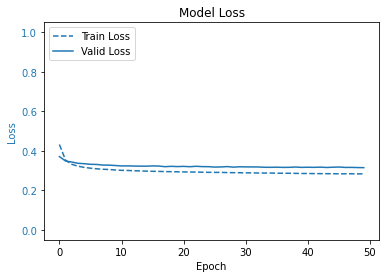

In [26]:
plot_loss(history)

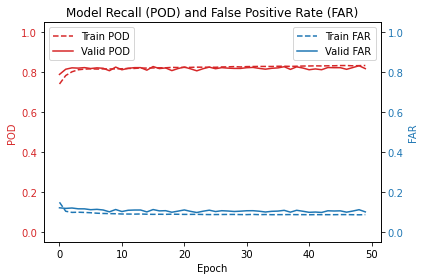

In [27]:
plot_model_recall_fpr(history)

In [28]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = mlp.predict(pca_val_in[:nsamples_val]).reshape(pca_val_in[:nsamples_val].shape[0]) # scaled_val_in.mean(axis=(1,2,3)).reshape(199399,1))
binary_preds = np.where(preds >= binary_threshold, 1, 0)
performance = perf_measure(val_out, binary_preds)

In [29]:
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.311
R squared: 0.595
Hellenger Distance: 0.441
Heidke Skill Score: 0.722
Pierce Skill Score: 0.718
Brier Score: 0.132
Brier Skill Score: 0.446
AUC: 0.859
Probability of detection: 0.818
False alarm ratio: 0.1
Accuracy: 0.868


## CNN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
reshaped_scaled_train_in = scaled_train_in.reshape(nsamples_train,nx,ny,nchannels)
reshaped_scaled_train_in.shape

(212604, 32, 32, 4)

In [20]:
reshaped_scaled_val_in = scaled_val_in.reshape(nsamples_val,nx,ny,nchannels)
reshaped_scaled_val_in.shape

(199399, 32, 32, 4)

In [21]:
mlp = Sequential()
mlp.add(Input(shape=reshaped_scaled_train_in.shape[1:]))
mlp.add(Conv2D(8, (3, 3), activation='relu'))
mlp.add(MaxPooling2D(2, 2))
mlp.add(Conv2D(8, (3, 3), activation='relu'))
mlp.add(MaxPooling2D(2, 2))
mlp.add(Conv2D(8, (3, 3), activation='relu'))
mlp.add(MaxPooling2D(2, 2))
mlp.add(Flatten())
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         296       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

In [22]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(), FalsePositiveRate()]
           )

In [23]:
%%time
history = mlp.fit(x=reshaped_scaled_train_in,
                  y=train_out,
                  batch_size=256,
                  epochs=25,
                  validation_data=(reshaped_scaled_val_in, val_out),
                  verbose=1).history

Epoch 1/25
831/831 [==============================] - 33s 39ms/step - loss: 0.3249 - accuracy: 0.8660 - recall: 0.8019 - false_positive_rate: 0.0972 - val_loss: 0.3273 - val_accuracy: 0.8629 - val_recall: 0.7519 - val_false_positive_rate: 0.0645
Epoch 2/25
831/831 [==============================] - 13s 16ms/step - loss: 0.2680 - accuracy: 0.8908 - recall: 0.8488 - false_positive_rate: 0.0851 - val_loss: 0.2961 - val_accuracy: 0.8784 - val_recall: 0.8416 - val_false_positive_rate: 0.0974
Epoch 3/25
831/831 [==============================] - 13s 16ms/step - loss: 0.2552 - accuracy: 0.8966 - recall: 0.8613 - false_positive_rate: 0.0830 - val_loss: 0.2886 - val_accuracy: 0.8814 - val_recall: 0.8121 - val_false_positive_rate: 0.0733
Epoch 4/25
831/831 [==============================] - 13s 16ms/step - loss: 0.2457 - accuracy: 0.9014 - recall: 0.8660 - false_positive_rate: 0.0782 - val_loss: 0.3296 - val_accuracy: 0.8591 - val_recall: 0.7153 - val_false_positive_rate: 0.0469
Epoch 5/25
831/8

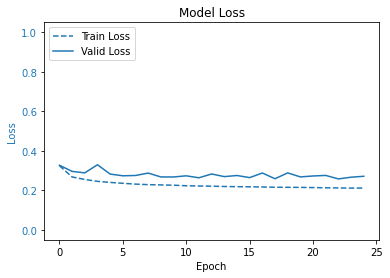

In [24]:
plot_loss(history)

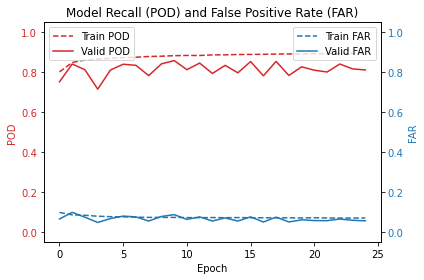

In [25]:
plot_model_recall_fpr(history)

In [27]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = mlp.predict(reshaped_scaled_val_in).reshape(reshaped_scaled_val_in.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)
performance = perf_measure(val_out, binary_preds)

In [28]:
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.285
R squared: 0.672
Hellenger Distance: 0.394
Heidke Skill Score: 0.771
Pierce Skill Score: 0.757
Brier Score: 0.108
Brier Skill Score: 0.549
AUC: 0.878
Probability of detection: 0.812
False alarm ratio: 0.055
Accuracy: 0.892


## LSTM model

In [31]:
import tensorflow as tf
tf.keras.backend.clear_session()

# (ti, ti+1, ti+2) are used to predict ti+3.
n_features = 32 # From pca.
window_size = 3
batch_size= 128
time_steps = pca_train_in.shape[0]

# Utility class for generating batches of temporal training data.
dg_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data=pca_train_in,
    targets=train_out,
    length=window_size,
    sampling_rate=1,
    stride=1,
    batch_size=batch_size
)

# Utility class for generating batches of temporal validation data.
dg_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data=pca_val_in,
    targets=val_out,
    length=window_size,
    sampling_rate=1,
    stride=1,
    batch_size=batch_size
)

In [32]:
# LSTM architecture.
model = model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(time_steps, n_features)),
    tf.keras.layers.Dense(4, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Model architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


In [33]:
%%time
# Prepare for training.
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

CPU times: user 9.59 ms, sys: 0 ns, total: 9.59 ms
Wall time: 8.03 ms


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.3990 - accuracy: 0.8357 - val_loss: 0.3401 - val_accuracy: 0.8661
Epoch 2/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.3075 - accuracy: 0.8819 - val_loss: 0.3255 - val_accuracy: 0.8743
Epoch 3/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.2942 - accuracy: 0.8891 - val_loss: 0.3186 - val_accuracy: 0.8784
Epoch 4/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.2878 - accuracy: 0.8918 - val_loss: 0.3167 - val_accuracy: 0.8790
Epoch 5/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.2835 - accuracy: 0.8948 - val_loss: 0.3149 - val_accuracy: 0.8805
Epoch 6/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.2808 - accuracy: 0.8957 - val_loss: 0.3138 - val_accuracy: 0.8822
Epoch 7/50
1661/1661 [==============================] 

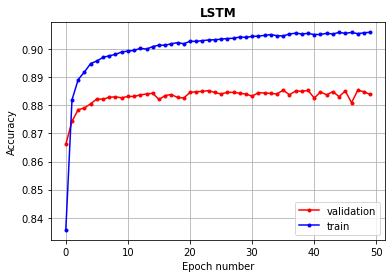

In [34]:
%%time
# Train!
history = model.fit_generator(
    generator=dg_train, 
    epochs=50, 
    verbose=1,
    validation_data=dg_val
)

# Accuracy as function of epochs.
plt.plot(history.history["val_accuracy"], ".-r", label="validation")
plt.plot(history.history["accuracy"],  ".-b", label="train")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.title("LSTM", weight="bold")
plt.legend()
plt.grid()

In [40]:
binary_threshold = 0.5
preds = model.predict(x=dg_val).reshape((-1, ))
binary_preds = np.where(preds >= binary_threshold, 1, 0)
performance = perf_measure(val_out[:preds.shape[0]], binary_preds)

print("\n>>> LSTM")

print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out[:preds.shape[0]], preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out[:preds.shape[0]], preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out[:preds.shape[0]], preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out[:preds.shape[0]], binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out[:preds.shape[0]], binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out[:preds.shape[0]], binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out[:preds.shape[0]], binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out[:preds.shape[0]], binary_preds),3)))
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))


>>> LSTM
RMSE: 0.286
R squared: 0.658
Hellenger Distance: 0.647
Heidke Skill Score: 0.77
Pierce Skill Score: 0.77
Brier Score: 0.11
Brier Skill Score: 0.541
AUC: 0.885
Probability of detection: 0.86
False alarm ratio: 0.09
Accuracy: 0.89


### Dense NN using lower-resolution patches

In [41]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [42]:
%%time
lowres_patch = 4
lowres_train_in = np.zeros((train_in.shape[0],lowres_patch,lowres_patch,nchannels))
for i in range(train_in.shape[0]):
    for k in range(nchannels):
        lowres_train_in[i,:,:,k] = rebin(train_in[i,:,:,k], (lowres_patch, lowres_patch))

CPU times: user 22.8 s, sys: 57.8 ms, total: 22.9 s
Wall time: 22 s


In [43]:
%%time
lowres_val_in = np.zeros((val_in.shape[0],lowres_patch,lowres_patch,nchannels))
for i in range(val_in.shape[0]):
    for k in range(nchannels):
        lowres_val_in[i,:,:,k] = rebin(val_in[i,:,:,k], (lowres_patch, lowres_patch))

CPU times: user 21.2 s, sys: 79.3 ms, total: 21.3 s
Wall time: 20.4 s


In [44]:
%%time
# use standard scaler, since this gave better results yesterday
scaler = StandardScaler()
lowres_scaled_train_in = scaler.fit_transform(lowres_train_in.reshape(lowres_train_in.shape[0],lowres_patch*lowres_patch*nchannels))#.reshape(lowres_train_in.shape[0],lowres_patch,lowres_patch,nchannels)
lowres_scaled_val_in = scaler.fit_transform(lowres_val_in.reshape(lowres_val_in.shape[0],lowres_patch*lowres_patch*nchannels))#.reshape(lowres_val_in.shape[0],lowres_patch,lowres_patch,nchannels)

CPU times: user 524 ms, sys: 140 ms, total: 664 ms
Wall time: 658 ms


In [45]:
lowres_scaled_train_in.shape

(212604, 64)

In [46]:
mlp = Sequential()
mlp.add(Input(shape=lowres_scaled_train_in.shape[1:]))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(8, activation='relu'))
mlp.add(Dense(4, activation='relu'))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 2,793
Trainable params: 2,793
Non-trainable params: 0
____________________________________________________

In [47]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(), FalsePositiveRate()]
           )

In [48]:
%%time
ntrain = scaled_train_in.shape[0]
nval   = scaled_val_in.shape[0]
history = mlp.fit(x=lowres_scaled_train_in,
                  y=train_out,
                  batch_size=512,
                  epochs=50,
                  validation_data=(lowres_scaled_val_in, val_out),
                  verbose=1).history

Epoch 1/50
416/416 [==============================] - 3s 8ms/step - loss: 0.5562 - accuracy: 0.8336 - recall: 0.7834 - false_positive_rate: 0.1388 - val_loss: 0.5055 - val_accuracy: 0.8483 - val_recall: 0.7884 - val_false_positive_rate: 0.1126
Epoch 2/50
416/416 [==============================] - 3s 7ms/step - loss: 0.4664 - accuracy: 0.8687 - recall: 0.7935 - false_positive_rate: 0.0880 - val_loss: 0.4475 - val_accuracy: 0.8554 - val_recall: 0.7702 - val_false_positive_rate: 0.0889
Epoch 3/50
416/416 [==============================] - 3s 7ms/step - loss: 0.4148 - accuracy: 0.8739 - recall: 0.7936 - false_positive_rate: 0.0799 - val_loss: 0.4176 - val_accuracy: 0.8578 - val_recall: 0.7623 - val_false_positive_rate: 0.0799
Epoch 4/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3797 - accuracy: 0.8772 - recall: 0.7999 - false_positive_rate: 0.0783 - val_loss: 0.3917 - val_accuracy: 0.8587 - val_recall: 0.7549 - val_false_positive_rate: 0.0736
Epoch 5/50
416/416 [====

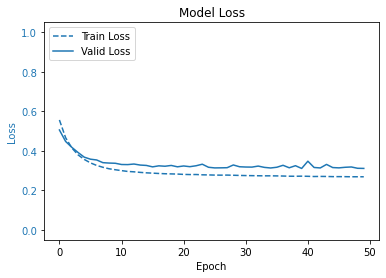

In [49]:
plot_loss(history)

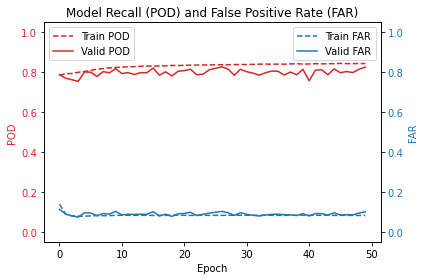

In [50]:
plot_model_recall_fpr(history)

In [53]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = mlp.predict(lowres_scaled_val_in).reshape(lowres_scaled_val_in.shape[0]) # scaled_val_in.mean(axis=(1,2,3)).reshape(199399,1))
binary_preds = np.where(preds >= binary_threshold, 1, 0)
performance = perf_measure(val_out, binary_preds)

In [54]:
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.308
R squared: 0.603
Hellenger Distance: 0.438
Heidke Skill Score: 0.728
Pierce Skill Score: 0.725
Brier Score: 0.13
Brier Skill Score: 0.457
AUC: 0.863
Probability of detection: 0.826
False alarm ratio: 0.101
Accuracy: 0.87
